# Импорт библиотек

In [16]:
import os
import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()
import numpy as np
import re
import pandas as pd
from scipy.stats import norm
import pint
ureg = pint.UnitRegistry()

%load_ext line_profiler

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


# Константы

In [17]:
pi = np.pi
speed_of_light = c = 299792458.0 * ureg.meters / ureg.seconds
electron_mass = m_e = 9.1093837015e-31 * ureg.kilogram
eps0 = 8.854188e-12 * ureg.farad / ureg.m
q_e = 9.10938356e-31 * ureg.coulomb

# Входные данные

In [18]:
Q = -100e-9 * ureg.coulomb # Заряд пучка
N = 200  # Макрочастиц в пучке

pos_offsets = offset_x, offset_y, offset_z = 0.02 * ureg.m, 0.02 * ureg.m, 0 * ureg.m # Средние значения координат
pos_sigmas = sigma_x, sigma_y, sigma_z = 1e-4 * ureg.m, 1e-4 * ureg.m, 0.004 * ureg.m # Отклонения кординат

W, dW = 50 * ureg.megaelectron_volt, 1 * ureg.megaelectron_volt # Энергия и её разброс

eps_x, eps_y = 1e-9 * ureg.mm * ureg.millirad, 1e-9 * ureg.mm * ureg.millirad  # Эммитансы

# Генерация пучка

In [27]:
class Particle:
    __slots__ = ("q", "pos", "pulse", "W")
    
    def __init__(self, q, pos, pulse, W=None):
        self.q = q
        self.pos = pos
        self.pulse = pulse
        if W is None:
            self.W = (c * np.sqrt(np.sum(self.pulse**2) + (m_e * c)**2)).to("megaelectron_volt")
        else:
            self.W = W
            
    def recount_enegrgy(self):
        self.W = (c * np.sqrt(np.sum(self.pulse**2) + (m_e * c)**2)).to("megaelectron_volt")
        
    def __str__(self):
        res = (
            "<class Particle>\n"
            f"Координата: {self.pos}\n"
            f"Импульс: {self.pulse}\n"
            f"Энергия: {self.W}\n"
            f"Заряд: {self.q}\n"
        )
        return res
    
    def to_si(self):
        old_system = ureg.default_system
        ureg.default_system = "SI"
        
        res = Particle(
            self.q.to_base_units(),
            self.pos.to_base_units(), 
            self.pulse.to_base_units(),
            self.W.to_base_units()
        )
        
        ureg.default_system = old_system
        
        return res
    
    def to_dict(self, magnitude=False):
        res = {
            "q": self.q,
            "w": self.W,
            "x": self.pos[0],
            "y": self.pos[1],
            "z": self.pos[2],
            "px": self.pulse[0],
            "py": self.pulse[1],
            "pz": self.pulse[2],
        }
        
        if magnitude:
            for key in res:
                res[key] = res[key].magnitude
        
        return res
    
    def __repr__(self):
        return str(self)

In [28]:
def generate_particle():
    q = Q / N  # Заряд макрочастицы

    # Генерация координат
    x = np.random.normal(offset_x.to("m").magnitude, sigma_x.to("m").magnitude)
    y = np.random.normal(offset_y.to("m").magnitude, sigma_y.to("m").magnitude) 
    z = np.random.normal(0, sigma_z.to("m").magnitude) 

    pos = np.array([x, y, z]) * ureg.m
   
    # Генерация импульсов и энергии
    mean_pulse_z = p0z = np.sqrt((W / c)**2 - (m_e * c)**2)
    sigma_pz = np.sqrt(((W+dW) / c)**2 - (m_e * c)**2) - p0z 

    gamma = (W / (m_e * c**2)).to_base_units()
    sigma_px = (eps_x * 0.0001 / (gamma * sigma_x)).to_base_units()
    sigma_py = (eps_y * 0.0001 / (gamma * sigma_y)).to_base_units()

    px = (np.random.normal(0, sigma_px) * p0z).to_base_units()
    py = (np.random.normal(0, sigma_py) * p0z).to_base_units()
    pz = np.random.normal(p0z.to_base_units().magnitude, sigma_pz.to_base_units().magnitude) * p0z.to_base_units().units

    pulse = np.array([px.to_base_units().magnitude, py.to_base_units().magnitude, pz.to_base_units().magnitude]) * px.to_base_units().units

    return Particle(q, pos, pulse)

generate_particle()

D:\Soft\miniconda3\lib\site-packages\ipykernel_launcher.py:19: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
D:\Soft\miniconda3\lib\site-packages\ipykernel_launcher.py:20: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.


<class Particle>
Координата: [0.02003784194739876 0.019912706583557552 0.003280646088225112] meter
Импульс: [-2.899454118419793e-37 7.330520422881128e-38 2.696118564540206e-20] kilogram * meter / second
Энергия: 50.451208518372596 megaelectron_volt
Заряд: -4.999999999999999e-10 coulomb

In [29]:
bunch = np.array([generate_particle() for _ in range(50)])

D:\Soft\miniconda3\lib\site-packages\ipykernel_launcher.py:19: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
D:\Soft\miniconda3\lib\site-packages\ipykernel_launcher.py:20: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.


In [41]:
df = pd.DataFrame([x.to_si().to_dict(magnitude=True) for x in bunch])
df.to_csv("data.csv", sep=" ", index=False)

# Вычисление силы Кулона

In [180]:
def get_coulomb_force(p1, p2):
    gamma = (p1.W / (m_e * c**2))
  
    r0 = np.sqrt(p1.pos[0]**2 + p1.pos[1]**2)
    if p1.pos[1] >= 0:
        teta0 = np.arccos((p1.pos[0] / r0) if r0 != 0 else 1) # Angle from [0; pi]
    else:
        teta0 = 2*pi - np.arccos((p1.pos[0] / r0) if r0 != 0 else 1)
   
    r = np.sqrt(p2.pos[0]**2 + p2.pos[1]**2)
    if p2.pos[1] >= 0:
        teta = np.arccos((p2.pos[0] / r) if r != 0 else 1) # Angle from [0; pi]
    else:
        teta = 2*pi - np.arccos((p2.pos[0] / r) if r != 0 else 1)
    
    dteta_sin = np.sin(teta - teta0)
    dteta_cos = np.cos(teta - teta0)
    
    z_hat = ((p1.pos[2] - p2.pos[2]) * gamma)
    denominator = np.power((np.power(r, 2) + np.power(r0, 2) - 2*r*r0*dteta_cos + np.power(z_hat, 2)), 3/2)
    
    Q = (p1.q * p2.q)
    
    # Формулы вручную сокращены во избежание потери точности
    F_r = (Q * (r - r0 * dteta_cos)) / (gamma * denominator)
    F_teta = (Q * (r0 * dteta_sin)) / (gamma * denominator)

    teta_sin = np.sin(teta)
    teta_cos = np.cos(teta)

    K = 1 / (4 * pi * eps0)
    Fx = K * (F_r * teta_cos - F_teta * teta_sin)
    Fy = K * (F_r * teta_sin + F_teta * teta_cos)
    Fz = K * (Q * z_hat / denominator)
   
    return [Fx.to_base_units(), Fy.to_base_units(), Fz.to_base_units()]

#%lprun -f get_coulomb_force get_coulomb_force(bunch[0], bunch[1])
[x.to_base_units() for x in get_coulomb_force(bunch[0], bunch[4])]

[-6.49495882937961e-05 <Unit('kilogram * meter / second ** 2')>,
 -6.49495882937961e-05 <Unit('kilogram * meter / second ** 2')>,
 0.0 <Unit('kilogram * meter / second ** 2')>]

# Динамика

In [157]:
# Частица действует сама на себя? Для черенковской силы?
# Поправка силы const ldouble abs_val = abs(q_e / data.bunches[s].p[0].q);
# Какая частица впереди?

dt = 1e-11 * ureg.sec
Rc = 2.5 * ureg.meter

In [183]:
from collections import defaultdict
from tqdm.notebook import tqdm

def get_forces(bunch, dimension="newton"):
    forces = [[0 * ureg(dimension)] * 3 for _ in bunch]

    for i in range(len(bunch)):
        p1 = bunch[i]
        for j in range(i+1, len(bunch)):
            p2 = bunch[j]

            fx, fy, fz = [x.to(dimension) for x in get_coulomb_force_cpp(p1, p2)]
            #print((i+1, j+1), (fx.magnitude, fy.magnitude, fz.magnitude))

            forces[j][0] += fx
            forces[j][1] += fy
            forces[j][2] += fz

            forces[i][0] -= fx
            forces[i][1] -= fy
            forces[i][2] -= fz
    
    return forces

# Визуализация

In [165]:
def plot_particles(df, Rc=None):
    #matplotlib.rcParams.update({'font.size': 22})

    if Rc:
        interval = (-Rc, Rc)
    
    xs, ys, zs = df["x"], df["y"], df["z"]
    
    fig = plt.figure(figsize=(20, 6))

    ax = fig.add_subplot(131)
    points = ax.scatter(xs, ys, s=10)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    if Rc:
        ax.set_xlim(*interval)
        ax.set_ylim(*interval)
    
    ax = fig.add_subplot(132)
    points = ax.scatter(xs, zs, s=10)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Z Label')
    if Rc:
        ax.set_xlim(*interval)

    ax = fig.add_subplot(133)
    points = ax.scatter(ys, zs, s=10)
    ax.set_xlabel('Y Label')
    ax.set_ylabel('Z Label')
    if Rc:
        ax.set_xlim(*interval)
        
    #cmap = sns.cubehelix_palette(as_cmap=True)
    #ax = fig.add_axes([0.92, 0.05, 0.02, 0.9])
    #cbar = plt.colorbar(points, cax=ax)
    #ax.set_ylabel('Energy, MeV', labelpad=15)

# Тесты

In [191]:
# Test 1
init_q = 0.2 * ureg("nanocoulomb")
init_pulse = np.array([0, 0, 0]) * ureg("kg * m / s")
init_W = 100 * ureg.megaelectron_volt

bunch = [
    Particle(init_q, np.array([ 0.01,  0.01, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([-0.01,  0.01, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([-0.01, -0.01, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([ 0.01, -0.01, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([ 0.00,  0.00, 0]) * ureg.cm, init_pulse, init_W),
]

for i, force in enumerate(get_forces(bunch, "dyne")):
    print(i+1, force)

1 [<Quantity(12.7113278, 'dyne')>, <Quantity(12.7113278, 'dyne')>, <Quantity(0.0, 'dyne')>]
2 [<Quantity(-12.7113278, 'dyne')>, <Quantity(12.7113278, 'dyne')>, <Quantity(0.0, 'dyne')>]
3 [<Quantity(-12.7113278, 'dyne')>, <Quantity(-12.7113278, 'dyne')>, <Quantity(0.0, 'dyne')>]
4 [<Quantity(12.7113278, 'dyne')>, <Quantity(-12.7113278, 'dyne')>, <Quantity(0.0, 'dyne')>]
5 [<Quantity(8.8817842e-16, 'dyne')>, <Quantity(0.0, 'dyne')>, <Quantity(0.0, 'dyne')>]


In [192]:
# Test 2
init_q = 0.2 * ureg("nanocoulomb")
init_pulse = np.array([0, 0, 0]) * ureg("kg * m / s")
init_W = 100 * ureg.megaelectron_volt

bunch = [
    Particle(init_q, np.array([ 0.01,  0.00, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([ 0.00,  0.01, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([-0.01,  0.00, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([ 0.00, -0.01, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([ 0.00,  0.00, 0]) * ureg.cm, init_pulse, init_W),
]

for i, force in enumerate(get_forces(bunch, "dyne")):
    print(i+1, force)

1 [<Quantity(35.9530643, 'dyne')>, <Quantity(-2.66453526e-15, 'dyne')>, <Quantity(0.0, 'dyne')>]
2 [<Quantity(2.57548307e-15, 'dyne')>, <Quantity(35.9530643, 'dyne')>, <Quantity(0.0, 'dyne')>]
3 [<Quantity(-35.9530643, 'dyne')>, <Quantity(5.80245322e-15, 'dyne')>, <Quantity(0.0, 'dyne')>]
4 [<Quantity(-6.92732299e-15, 'dyne')>, <Quantity(-35.9530643, 'dyne')>, <Quantity(0.0, 'dyne')>]
5 [<Quantity(3.37460931e-15, 'dyne')>, <Quantity(-3.55271368e-15, 'dyne')>, <Quantity(0.0, 'dyne')>]


In [195]:
# Test 3
init_q = 0.2 * ureg("nanocoulomb")
init_pulse = np.array([0, 0, 0]) * ureg("kg * m / s")
init_W = 100 * ureg.megaelectron_volt

bunch = [
    Particle(init_q, np.array([ 0.02,  0.00, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([ 0.01,  0.00, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([-0.01,  0.00, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([-0.02,  0.00, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([ 0.00,  0.00, 0]) * ureg.cm, init_pulse, init_W),
]

for i, force in enumerate(get_forces(bunch, "dyne")):
    print(i+1, force)

1 [<Quantity(26.1524727, 'dyne')>, <Quantity(-1.53628047e-16, 'dyne')>, <Quantity(0.0, 'dyne')>]
2 [<Quantity(6.63379797, 'dyne')>, <Quantity(-4.47864816e-16, 'dyne')>, <Quantity(0.0, 'dyne')>]
3 [<Quantity(-6.63379797, 'dyne')>, <Quantity(3.64541129e-16, 'dyne')>, <Quantity(0.0, 'dyne')>]
4 [<Quantity(-26.1524727, 'dyne')>, <Quantity(3.04912616e-15, 'dyne')>, <Quantity(0.0, 'dyne')>]
5 [<Quantity(1.77635684e-15, 'dyne')>, <Quantity(-2.81217442e-15, 'dyne')>, <Quantity(0.0, 'dyne')>]


In [196]:
# Test 4
init_q = 0.2 * ureg("nanocoulomb")
init_pulse = np.array([0, 0, 0]) * ureg("kg * m / s")
init_W = 100 * ureg.megaelectron_volt

bunch = [
    Particle(init_q, np.array([ 0.00,  0.02, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([ 0.00,  0.01, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([ 0.00, -0.01, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([ 0.00, -0.02, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([ 0.00,  0.00, 0]) * ureg.cm, init_pulse, init_W),
]

for i, force in enumerate(get_forces(bunch, "dyne")):
    print(i+1, force)

1 [<Quantity(1.75500515e-15, 'dyne')>, <Quantity(26.1524727, 'dyne')>, <Quantity(0.0, 'dyne')>]
2 [<Quantity(8.54067788e-16, 'dyne')>, <Quantity(6.63379797, 'dyne')>, <Quantity(0.0, 'dyne')>]
3 [<Quantity(-7.70744101e-16, 'dyne')>, <Quantity(-6.63379797, 'dyne')>, <Quantity(0.0, 'dyne')>]
4 [<Quantity(-4.65050326e-15, 'dyne')>, <Quantity(-26.1524727, 'dyne')>, <Quantity(0.0, 'dyne')>]
5 [<Quantity(2.81217442e-15, 'dyne')>, <Quantity(1.77635684e-15, 'dyne')>, <Quantity(0.0, 'dyne')>]


# Вызов кода на C++

In [158]:
df = pd.DataFrame([x.to_si().to_dict(magnitude=True) for x in bunch])
df.head()

,q,w,x,y,z,px,py,pz
0,2.000000e-10,1.602177e-11,0.0001,0.0001,0.0,0.0,0.0,0.0
1,2.000000e-10,1.602177e-11,-0.0001,0.0001,0.0,0.0,0.0,0.0
2,2.000000e-10,1.602177e-11,-0.0001,-0.0001,0.0,0.0,0.0,0.0
3,2.000000e-10,1.602177e-11,0.0001,-0.0001,0.0,0.0,0.0,0.0
4,2.000000e-10,1.602177e-11,0.0000,0.0000,0.0,0.0,0.0,0.0


In [166]:
import subprocess

df.to_csv("data.csv", sep=" ", index=False)
exe_path = "./console_particles_cpu/build/particles"
subprocess.call([str(x) for x in [exe_path, Rc.magnitude, dt.magnitude]])
df = pd.read_csv("res.csv", sep=" ")
df.head()

,q,w,x,y,z,px,py,pz
0,2.000000e-10,1.602177e-11,-1.426105e+02,-1.426105e+02,0.0,-1.271133e-15,-1.271133e-15,0.0
1,2.000000e-10,1.602177e-11,1.426105e+02,-1.426105e+02,0.0,1.271133e-15,-1.271133e-15,0.0
2,2.000000e-10,1.602177e-11,1.426105e+02,1.426105e+02,0.0,1.271133e-15,1.271133e-15,0.0
3,2.000000e-10,1.602177e-11,-1.426105e+02,1.426105e+02,0.0,-1.271133e-15,1.271133e-15,0.0
4,2.000000e-10,1.602177e-11,-1.520482e-14,-3.040963e-14,0.0,-1.355253e-31,-2.710505e-31,0.0


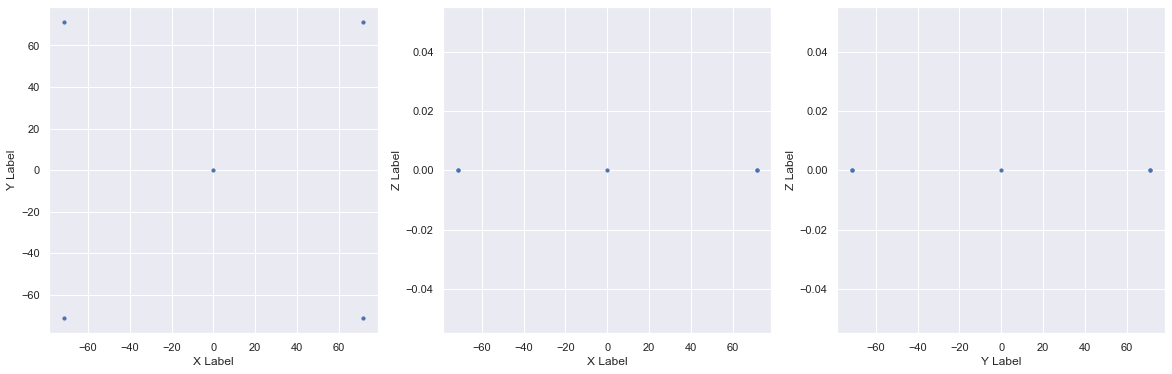

In [162]:
plot_particles(df)

In [188]:
import subprocess

def get_coulomb_force_cpp(p1, p2):
    bunch = [p1, p2]
    
    df = pd.DataFrame([x.to_si().to_dict(magnitude=True) for x in bunch])
    df.to_csv("data.csv", sep=" ", index=False)
    
    exe_path = "./console_particles_cpu/build/getcoulombforce"
    subprocess.call(exe_path)
    df = pd.read_csv("res.csv", sep=" ")
    
    return [x * ureg("newton") for x in df.iloc[0].values]

In [189]:
get_coulomb_force_cpp(bunch[0], bunch[1])

[-4.592629360442464e-05 <Unit('newton')>,
 3.544964046332402e-21 <Unit('newton')>,
 0.0 <Unit('newton')>]

In [190]:
get_coulomb_force(bunch[0], bunch[1])

[-4.5926294317817636e-05 <Unit('kilogram * meter / second ** 2')>,
 3.540148042211333e-21 <Unit('kilogram * meter / second ** 2')>,
 0.0 <Unit('kilogram * meter / second ** 2')>]